In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from tqdm import tqdm
import glob
import os
import re
import csv
from pathlib import Path
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.colors as mcolors
from pathlib import Path

In [35]:
# --- Parameters ---
num_fils = 348
num_segs = 20
num_steps = 500
num_blobs = 23302
sphere_radius = 197.6 

# --- File Paths ---
# Make sure to use the correct simulation data path
sim_name = 'cell_gaps_2'
date = '20250922'
base_path = f'../data/{sim_name}/{date}/ciliate_{num_fils}fil_{num_blobs}blob_8.00R_0.1500torsion_0.2182tilt_0.3000f_eff_1.4960theta0_0.0000freqshift'
seg_file_path = f'{base_path}_seg_states.dat'
phase_file_path = f'{base_path}_true_states.dat'

# --- Load Data ---
seg_data = np.loadtxt(seg_file_path)
phase_data = np.loadtxt(phase_file_path)

# --- Process Data ---
time = phase_data[:, 0] / num_steps
num_steps = len(time)

# Reshape segment data: (time, num_fils, num_segs, 3)
seg_positions = seg_data[:, 1:].reshape(num_steps, num_fils, num_segs, 3)

# Extract phases: (time, num_fils)
phases = np.mod(phase_data[:, 2:num_fils+2], 2*np.pi)

In [36]:
# --- Create Kymograph Plots ---
total_sims = len(files)

if total_sims == 0:
    print("No simulation files found.")
else:
    plt.rcParams.update({"font.size": 16})

    # Plotting function
    def plot_kymograph(time, phases, title):
        fig, ax = plt.subplots(figsize=(24, 12))
        position = np.linspace(0, 2*np.pi, num_fils)
        xx, yy = np.meshgrid(time, position)
        im = ax.contourf(
            xx, yy, phases.T, cmap=cmc.romaO, levels=np.linspace(0, 2*np.pi, 100)
        )

        n_sections = 12
        y0, y1 = 0.0, 2*np.pi
        for y in np.linspace(y0, y1, n_sections + 1)[1:-1]:
            ax.axhline(y, color="black", lw=1.0, alpha=1.0, zorder=5)

        
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(r'$\psi_1$')
        cbar.set_ticks([0, np.pi, 2*np.pi])
        cbar.set_ticklabels([r'$0$', r'$\pi$', r'$2\pi$'])
        
        ax.set_xlabel(r'$t/T$')
        ax.set_ylabel('angular position')
        ax.set_title(title)
        ax.set_yticks([0, 2*np.pi])
        ax.set_yticklabels([r'$0$', r'$2\pi$'])
        
        plt.tight_layout()
        plt.show()

    # Plot all 'with tilt' simulations
    for i in range(total_sims):
        params = get_params_from_path(files[i])
        title = f'cell gaps (sim {i+1})'
        plot_kymograph(times[i], phases[i], title)

    plt.rcParams.update(plt.rcParamsDefault)

TypeError: Input z must be 2D, not 1D

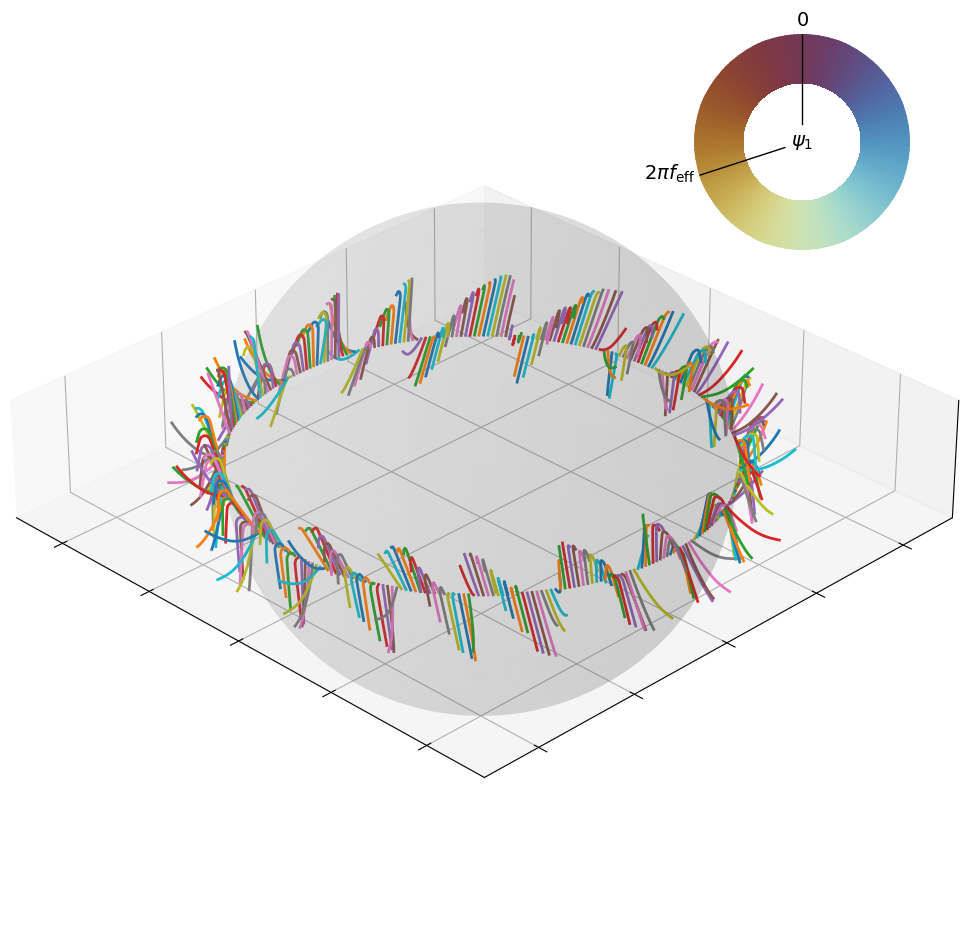

In [ ]:
plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    "font.size": 20  # Set the font size here
})

# --- Preview First Frame ---
fig_preview = plt.figure(figsize=(12, 12))
ax_preview = fig_preview.add_subplot(111, projection='3d')

# Setup colormap
cmap = cmc.romaO
norm = mcolors.Normalize(vmin=0, vmax=2*np.pi)

# Plot the sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = sphere_radius * np.outer(np.cos(u), np.sin(v))
y_sphere = sphere_radius * np.outer(np.sin(u), np.sin(v))
z_sphere = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax_preview.plot_surface(x_sphere, y_sphere, z_sphere, color='grey', alpha=0.1)

# Set axis limits based on the initial positions of the cilia
x_coords = seg_positions[0, :, :, 0]
y_coords = seg_positions[0, :, :, 1]
z_coords = seg_positions[0, :, :, 2]

margin = 2.0
ax_preview.set_xlim(np.min(x_coords) - margin, np.max(x_coords) + margin)
ax_preview.set_ylim(np.min(y_coords) - margin, np.max(y_coords) + margin)
ax_preview.set_zlim(np.min(z_coords) - margin, np.max(z_coords) + margin)

ax_preview.set_xlabel('')
ax_preview.set_ylabel('')
ax_preview.set_zlabel('')
ax_preview.set_xticklabels([])
ax_preview.set_yticklabels([])
ax_preview.set_zticklabels([])
ax_preview.set_title(r'')
ax_preview.set_aspect('equal')
ax_preview.grid(True, alpha=0.3)

# Hide z-ticks
ax_preview.set_zticks([])

# Set view angle for isometric view
ax_preview.view_init(elev=30, azim=-45)

# Plot each cilium for the first frame
for i in range(num_fils):
    cilium_positions = seg_positions[-1, i, :, :]
    x_data = cilium_positions[:, 0]
    y_data = cilium_positions[:, 1]
    z_data = cilium_positions[:, 2]
    ax_preview.plot(x_data, y_data, z_data, '-', lw=2) #, color=cmap(norm(phases[-1, i])))

# Add a colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = fig_preview.colorbar(sm, ax=ax_preview, orientation='vertical', fraction=0.046, pad=0.05)
# cbar.set_label(r'$\psi_1$', rotation=0, labelpad=-30, va='center')
# # Set custom ticks for the colorbar
# cbar.set_ticks([0, 0.6*np.pi, 2*np.pi])
# cbar.set_ticklabels([r'$0$', r'$2\pi f_{\mathrm{eff}}$', r'$2\pi$'])

# Replace the rectangular colorbar with a circular inset legend
# (maps angle θ to ψ1 in [0, 2π])
# sm/cbar removed

# Place a polar inset in the top-right of the 3D axes
fig_preview.canvas.draw()  # ensure bbox is valid before querying
bbox = ax_preview.get_position()  # figure coords [0..1]
side = 0.18                       # inset size (fraction of figure)
pad  = 0.02                       # padding from top-right

# Clamp so left/bottom are finite and in [0, 1-side]
left   = np.clip(bbox.x1 - side - pad, 0.0, 1.0 - side)
bottom = np.clip(bbox.y1 - side - pad, 0.0, 1.0 - side)
circ = fig_preview.add_axes([left, bottom, side, side], projection='polar')

# Build a colored ring
theta = np.linspace(0, 2*np.pi, 361)
r = np.linspace(0.82, 1.00, 2)    # thin ring
Theta, R = np.meshgrid(theta, r)
Z = Theta                          # values -> colormap in [0, 2π]
im_circ = circ.pcolormesh(Theta, R, Z, cmap=cmap, shading='auto', vmin=0, vmax=2*np.pi)

# Style the circular legend
circ.set_yticks([]); circ.set_xticks([])
circ.spines['polar'].set_visible(False)
circ.set_theta_zero_location('N')
circ.set_theta_direction(-1)
circ.set_rlim(0.78, 1.02)

# Center label in axes coords (avoid polar-data transform issues)
circ.text(0.5, 0.5, r'$\psi_1$', ha='center', va='center', fontsize=14, transform=circ.transAxes)

# Build a colored ring
theta = np.linspace(0, 2*np.pi, 361)
r_inner, r_outer = 0.82, 1.50
Theta, R = np.meshgrid(theta, np.linspace(r_inner, r_outer, 2))
Z = Theta
im_circ = circ.pcolormesh(Theta, R, Z, cmap=cmap, shading='auto', vmin=0, vmax=2*np.pi)

# Style the circular legend
circ.set_yticks([]); circ.set_xticks([])
circ.spines['polar'].set_visible(False)
circ.set_theta_zero_location('N')
circ.set_theta_direction(1)
circ.set_rlim(0.78, 1.02)

# --- Add radial lines and labels at ψ1 = 0 and ψ1 = 2π f_eff ---
theta0 = 0.0
theta_eff = 0.6*np.pi  # same angle you used for the colorbar tick (2π f_eff)

# Guide lines
circ.plot([theta0, theta0],   [r_inner, r_outer], color='k', lw=1.0, zorder=10)
circ.plot([theta_eff, theta_eff], [r_inner, r_outer], color='k', lw=1.0, zorder=10)

# Labels farther from the center (keep <= rlim max)
r_label = 1.1
circ.text(theta0,  1.03, r'$0$', ha='center', va='bottom', fontsize=14,
          transform=circ.transData, clip_on=False, zorder=11)
circ.text(theta_eff, 1.09, r'$2\pi f_{\mathrm{eff}}$', ha='center', va='bottom', fontsize=14,
          transform=circ.transData, clip_on=False, zorder=11)

plt.show()

In [ ]:
cmap(norm(phases[0, 1]))

(0.629367, 0.391713, 0.170869, 1.0)

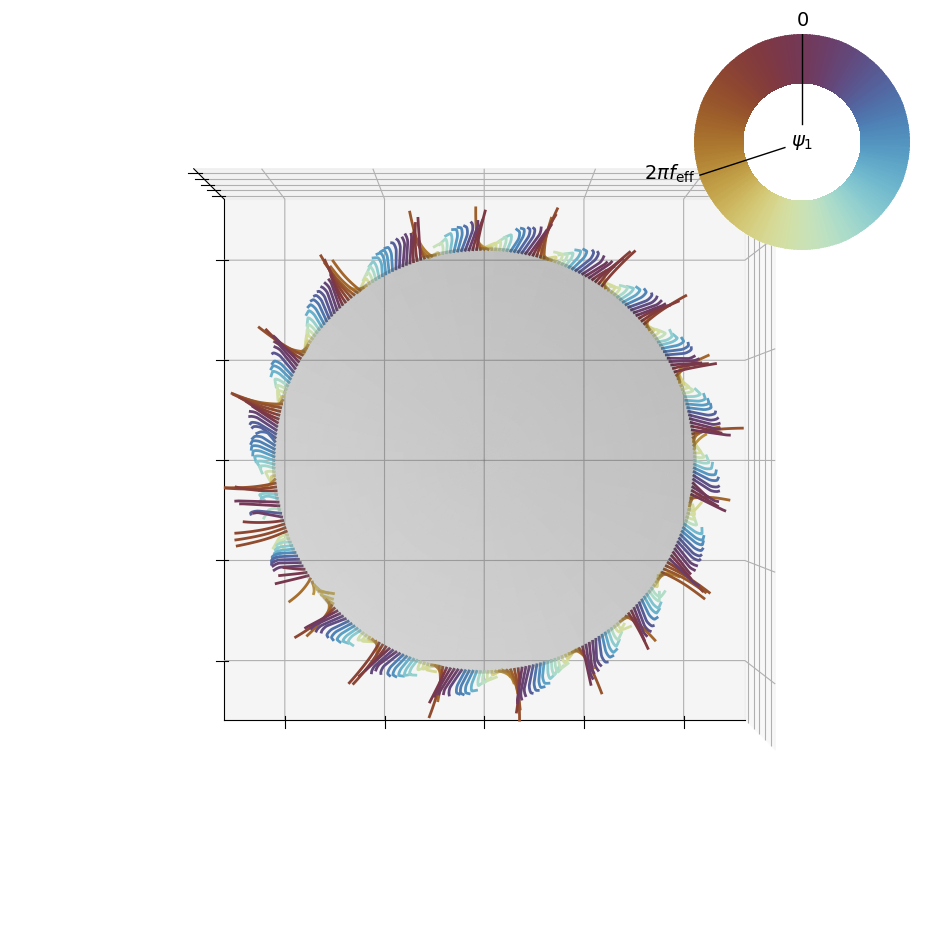

In [ ]:
# Compute global bounds once so preview matches the video framing
x_all = seg_positions[..., 0]
y_all = seg_positions[..., 1]
z_all = seg_positions[..., 2]
margin = 2.0
xlim = (float(np.min(x_all)) - margin, float(np.max(x_all)) + margin)
ylim = (float(np.min(y_all)) - margin, float(np.max(y_all)) + margin)
zlim = (float(np.min(z_all)) - margin, float(np.max(z_all)) + margin)

# Colormap
cmap = cmc.romaO
norm = mcolors.Normalize(vmin=0, vmax=2*np.pi)

# Figure
fig_td = plt.figure(figsize=(12, 12))
ax_td = fig_td.add_subplot(111, projection='3d')

# Axes limits and top-down view
ax_td.set_xlim(*xlim)
ax_td.set_ylim(*ylim)
ax_td.set_zlim(*zlim)
ax_td.view_init(elev=90, azim=-90)  # top-down
ax_td.set_box_aspect((1, 1, 1))
# ax_td.grid(False)  # grid off to keep background clean

# Hide all axis labels/ticks
ax_td.set_xlabel('')
ax_td.set_ylabel('')
ax_td.set_zlabel('')
ax_td.set_xticklabels([])
ax_td.set_yticklabels([])
ax_td.set_zticklabels([])

# Plot the sphere (light)
u = np.linspace(0, 2*np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = sphere_radius * np.outer(np.cos(u), np.sin(v))
y_sphere = sphere_radius * np.outer(np.sin(u), np.sin(v))
z_sphere = sphere_radius * np.outer(np.ones(np.size(u)), np.cos(v))
ax_td.plot_surface(x_sphere, y_sphere, z_sphere, color='grey', alpha=0.15, linewidth=0, antialiased=True)

# Plot each cilium at frame 0
frame = -1
for i in range(num_fils):
    XYZ = seg_positions[frame, i, :, :]
    ax_td.plot(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], '-', lw=2, color=cmap(norm(phases[frame, i])))

# Circular legend (with radial guides)
fig_td.canvas.draw()
bbox = ax_td.get_position()
side = 0.18
pad  = 0.02
left   = np.clip(bbox.x1 - side - pad, 0.0, 1.0 - side)
bottom = np.clip(bbox.y1 - side - pad, 0.0, 1.0 - side)
circ = fig_td.add_axes([left, bottom, side, side], projection='polar')

# Build a colored ring
theta = np.linspace(0, 2*np.pi, 361)
r = np.linspace(0.82, 1.00, 2)    # thin ring
Theta, R = np.meshgrid(theta, r)
Z = Theta                          # values -> colormap in [0, 2π]
im_circ = circ.pcolormesh(Theta, R, Z, cmap=cmap, shading='auto', vmin=0, vmax=2*np.pi)

# Style the circular legend
circ.set_yticks([]); circ.set_xticks([])
circ.spines['polar'].set_visible(False)
circ.set_theta_zero_location('N')
circ.set_theta_direction(-1)
circ.set_rlim(0.78, 1.02)

# Center label in axes coords (avoid polar-data transform issues)
circ.text(0.5, 0.5, r'$\psi_1$', ha='center', va='center', fontsize=14, transform=circ.transAxes)

# Build a colored ring
theta = np.linspace(0, 2*np.pi, 361)
r_inner, r_outer = 0.82, 1.50
Theta, R = np.meshgrid(theta, np.linspace(r_inner, r_outer, 2))
Z = Theta
im_circ = circ.pcolormesh(Theta, R, Z, cmap=cmap, shading='auto', vmin=0, vmax=2*np.pi)

# Style the circular legend
circ.set_yticks([]); circ.set_xticks([])
circ.spines['polar'].set_visible(False)
circ.set_theta_zero_location('N')
circ.set_theta_direction(1)
circ.set_rlim(0.78, 1.02)

# --- Add radial lines and labels at ψ1 = 0 and ψ1 = 2π f_eff ---
theta0 = 0.0
theta_eff = 0.6*np.pi  # same angle you used for the colorbar tick (2π f_eff)

# Guide lines
circ.plot([theta0, theta0],   [r_inner, r_outer], color='k', lw=1.0, zorder=10)
circ.plot([theta_eff, theta_eff], [r_inner, r_outer], color='k', lw=1.0, zorder=10)

# Labels farther from the center (keep <= rlim max)
r_label = 1.1
circ.text(theta0,  1.03, r'$0$', ha='center', va='bottom', fontsize=14,
          transform=circ.transData, clip_on=False, zorder=11)
circ.text(theta_eff, 1.09, r'$2\pi f_{\mathrm{eff}}$', ha='center', va='bottom', fontsize=14,
          transform=circ.transData, clip_on=False, zorder=11)

plt.show()

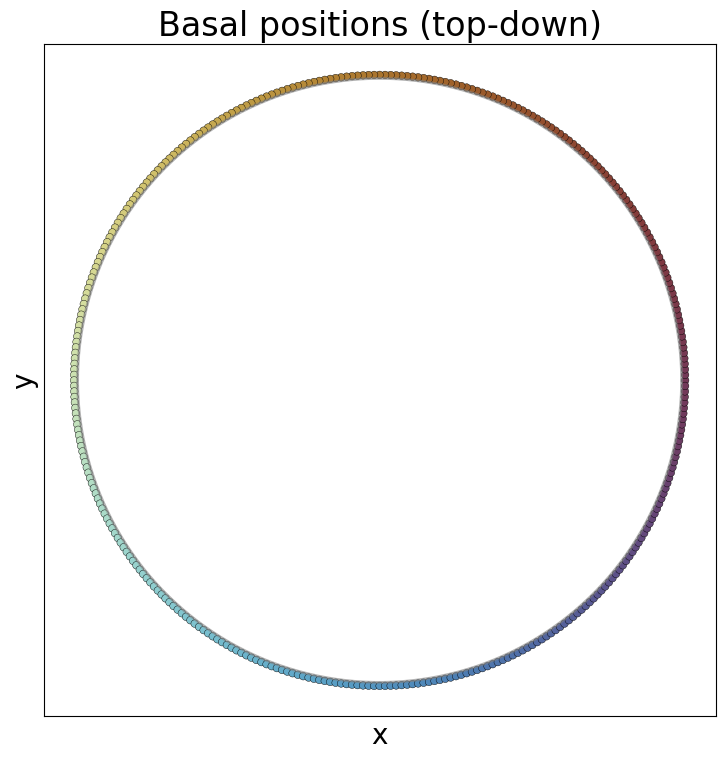

In [ ]:
# Basal (reference) positions: single line "x1 y1 z1 x2 y2 z2 ... xN yN zN"
fil_ref_file = f"{base_path}_fil_references.dat"
if not os.path.isfile(fil_ref_file):
    raise FileNotFoundError(f"Missing file: {fil_ref_file}")

raw = np.loadtxt(fil_ref_file).ravel()          # flatten in case
if raw.size % 3 != 0:
    raise ValueError(f"Reference file length {raw.size} not divisible by 3.")

N_file = raw.size // 3
if N_file != num_fils:
    print(f"Warning: num_fils ({num_fils}) != positions in file ({N_file}); using {N_file}.")
    num_plot = N_file
else:
    num_plot = num_fils

basal_pos = raw.reshape(num_plot, 3)
x = basal_pos[:, 0]
y = basal_pos[:, 1]
# z = basal_pos[:, 2]  # not needed for top-down

# Azimuthal angle coloring
angles = np.mod(np.arctan2(y, x), 2*np.pi)

fig, ax = plt.subplots(figsize=(8, 8))
sc = ax.scatter(x, y, c=angles, cmap=cmc.romaO, s=30, edgecolor='k', linewidth=0.3)

# Sphere equator outline
theta = np.linspace(0, 2*np.pi, 400)
ax.plot(sphere_radius * np.cos(theta), sphere_radius * np.sin(theta),
        color='grey', lw=2, alpha=0.6)

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Basal positions (top-down)')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

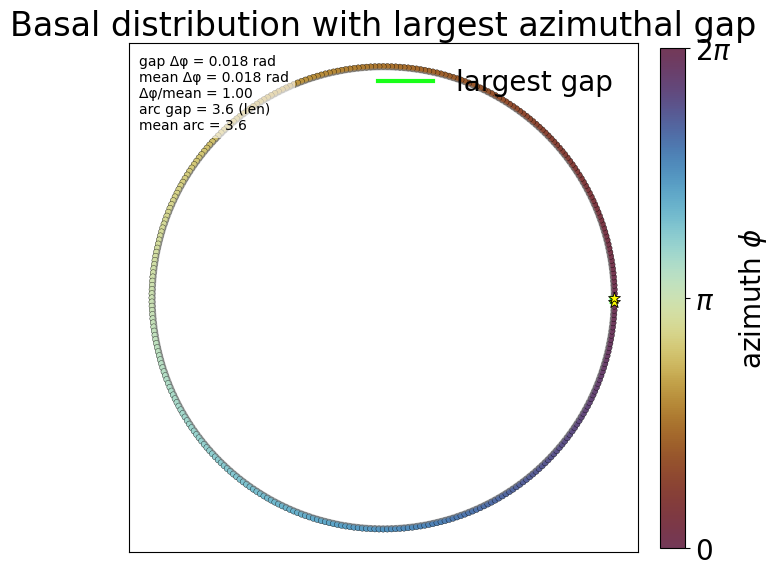

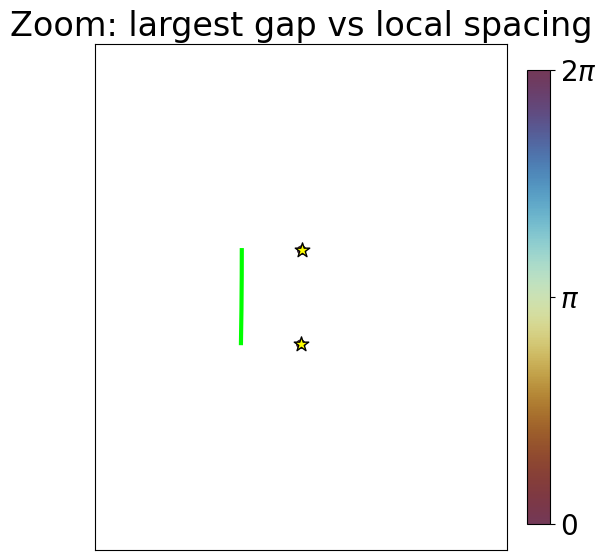

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

# If basal_pos not yet defined (single-line file of x1 y1 z1 ...):
if 'basal_pos' not in globals():
    fil_ref_file = f"{base_path}_fil_references.dat"
    raw = np.loadtxt(fil_ref_file).ravel()
    assert raw.size % 3 == 0, "Bad fil_references file length"
    basal_pos = raw.reshape(raw.size//3, 3)

x = basal_pos[:,0]
y = basal_pos[:,1]

R = sphere_radius  # already defined
phi = np.mod(np.arctan2(y, x), 2*np.pi)

# Sort and compute angular spacings
idx = np.argsort(phi)
phi_sorted = phi[idx]
phi_ext = np.concatenate([phi_sorted, [phi_sorted[0] + 2*np.pi]])
dphi = np.diff(phi_ext)

max_gap_i = np.argmax(dphi)
gap_width = dphi[max_gap_i]            # radians
gap_start = phi_sorted[max_gap_i]
gap_end_unwrapped = gap_start + gap_width
gap_end = np.mod(gap_end_unwrapped, 2*np.pi)
gap_center = np.mod(gap_start + 0.5*gap_width, 2*np.pi)

# Adjacent cilia (indices in original ordering)
cil_left_idx = idx[max_gap_i]
cil_right_idx = idx[(max_gap_i + 1) % len(phi_sorted)]

# Spacing stats (exclude largest gap)
mean_spacing = np.mean(np.delete(dphi, max_gap_i))
median_spacing = np.median(np.delete(dphi, max_gap_i))
gap_arc_len = R * gap_width
mean_arc_len = R * mean_spacing
ratio_gap_to_mean = gap_width / mean_spacing

# Build continuous arc angles for drawing (handle wrap)
if gap_end_unwrapped <= 2*np.pi:
    arc_angles = np.linspace(gap_start, gap_end_unwrapped, 200)
else:
    # wraps past 2π
    arc_angles = np.linspace(gap_start, gap_end_unwrapped, 200)
arc_x = R * np.cos(arc_angles)
arc_y = R * np.sin(arc_angles)

# Global plot with highlighted gap
fig, ax = plt.subplots(figsize=(7,7))
sc = ax.scatter(x, y, c=phi, cmap=cmc.romaO, s=20, edgecolor='k', linewidth=0.25)

# Highlight bounding cilia
ax.scatter([x[cil_left_idx], x[cil_right_idx]],
           [y[cil_left_idx], y[cil_right_idx]],
           c='yellow', s=80, edgecolor='k', linewidth=0.6, zorder=5, marker='*')

# Gap arc
ax.plot(arc_x, arc_y, color='lime', lw=3, alpha=0.9, label='largest gap')

# Outline circle
theta_circle = np.linspace(0, 2*np.pi, 600)
ax.plot(R*np.cos(theta_circle), R*np.sin(theta_circle), color='grey', lw=1.5, alpha=0.6)

ax.set_aspect('equal')
ax.set_xticks([]); ax.set_yticks([])
ax.set_title('Basal distribution with largest azimuthal gap')

cbar = fig.colorbar(sc, ax=ax, fraction=0.045, pad=0.04)
cbar.set_label(r'azimuth $\phi$')
cbar.set_ticks([0, np.pi, 2*np.pi])
cbar.set_ticklabels([r'$0$', r'$\pi$', r'$2\pi$'])

ax.legend(loc='upper right', frameon=False)

txt = (f"gap Δφ = {gap_width:.3f} rad\n"
       f"mean Δφ = {mean_spacing:.3f} rad\n"
       f"Δφ/mean = {ratio_gap_to_mean:.2f}\n"
       f"arc gap = {gap_arc_len:.1f} (len)\n"
       f"mean arc = {mean_arc_len:.1f}")
ax.text(0.02, 0.98, txt, ha='left', va='top', transform=ax.transAxes,
        fontsize=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.tight_layout()
plt.show()

# Zoom-in around gap (window = 1.3 * gap width around center)
window = 1.3 * gap_width
def ang_dist(a, b):
    d = np.abs(a - b)
    return np.minimum(d, 2*np.pi - d)

mask = ang_dist(phi, gap_center) <= 0.5*window
xz = x[mask]; yz = y[mask]; phiz = phi[mask]

fig2, ax2 = plt.subplots(figsize=(6,6))
sc2 = ax2.scatter(xz, yz, c=phiz, cmap=cmc.romaO, s=40, edgecolor='k', linewidth=0.4)

# Re-plot gap arc clipped to window (optional)
arc_mask = ang_dist(np.mod(arc_angles, 2*np.pi), gap_center) <= 0.5*window
ax2.plot(arc_x[arc_mask], arc_y[arc_mask], color='lime', lw=3)

# Mark the two boundary cilia if inside window
for cid in [cil_left_idx, cil_right_idx]:
    if ang_dist(phi[cid], gap_center) <= 0.5*window:
        ax2.scatter(x[cid], y[cid], c='yellow', s=120, edgecolor='k', marker='*', zorder=6)

# Set tight limits
pad = 0.04 * R
ax2.set_xlim(xz.min()-pad, xz.max()+pad)
ax2.set_ylim(yz.min()-pad, yz.max()+pad)
ax2.set_aspect('equal')
ax2.set_xticks([]); ax2.set_yticks([])
ax2.set_title('Zoom: largest gap vs local spacing')

cbar2 = fig2.colorbar(sc2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_ticks([0, np.pi, 2*np.pi])
cbar2.set_ticklabels([r'$0$', r'$\pi$', r'$2\pi$'])

plt.tight_layout()
plt.show()